# Loading a 3x3 model and transforming it to a 4x4

Below is shown how to load in a 3x3 model and then how to scale it up to be a 4x4.

First we load in packaged, so that it should be able to be run indapendently

In [66]:
import matplotlib.pyplot as plt

import pandas as pd


import numpy as np
from stable_baselines3 import A2C, DDPG, SAC, PPO, TD3
from matplotlib import axis


from gym.envs.my_collection import FlorisEnv 


import os
from Custom_functions import CustomEnv2
import torch

from floris.tools.visualization import visualize_cut_plane
from floris.tools import FlorisInterface
import copy

We then create the models, one is loaded from a trained agent, the other is created on a 4x4 farm.

We then save the parameters to a dict. This dict is then edited.

In [26]:
env1 = CustomEnv2(nx = 3, ny = 3)
env2 = CustomEnv2(nx = 4, ny = 4)

#model1 = A2C("MlpPolicy", env1, policy_kwargs=policy_kwargs, verbose=1)
model1 = A2C.load("models/A2C14/970000")    #trained on env2
model2 = A2C("MlpPolicy", env2, verbose=1)


test = model1.policy.named_parameters()
target_test = model2.policy.named_parameters()

test_dict = dict(test)
target_dict = dict(target_test)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [27]:
# first we create a "key", that shows the number of turbines and then a matching "key" A is for the 3x3 farm and B is the recieving farm.
A_key = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
B_key = np.array([[1, 2, 2, 3], [4, 5, 5, 6], [4, 5, 5, 6], [7, 8, 8, 9]])

A_key_flat = A_key.flatten()
B_key_flat = B_key.flatten()

with torch.no_grad():
    for name in target_dict:
        #print(name)
        if name == "log_std":
            for i in range(len(B_key_flat)):
                x = np.where(A_key_flat == B_key_flat[i]) #does the mapping from 3x3 to 4x4 farm.
                target_dict[name][i] = test_dict[name][x[0]]
            print("log std done")
        elif name == "action_net.weight":
            for i in range(len(B_key_flat)):
                x = np.where(A_key_flat == B_key_flat[i]) #does the mapping from 3x3 to 4x4 farm.
                target_dict[name][i] = test_dict[name][x[0]]
            print("Action weight done")
        elif name =="action_net.bias":
            for i in range(len(B_key_flat)):
                x = np.where(A_key_flat == B_key_flat[i]) #does the mapping from 3x3 to 4x4 farm.
                target_dict[name][i] = test_dict[name][x[0]]
            print("Action bias done")
        else:
            target_dict[name] = test_dict[name]


model2.policy.load_state_dict(target_dict) #loads the model back.
print("Model is now loaded back in")

log std done
Action weight done
Action bias done


In [67]:
# We then make a prediction, to get the yaw actions.

winddir = np.array(270)
env2.fi.reinitialize(
            wind_directions=[winddir],
            turbulence_intensity= 0.07,
            wind_speeds=[7]
            )

obs_scaled = env2.scale_obs(ws=np.array(7), wd=winddir, TI=np.array(0.07))
action, _states = model2.predict(obs_scaled, deterministic=True)
action *= env2.yaw_max
print(action)


[ 4.4151707   0.62763476  0.62763476  1.987197    2.6172957   1.5046848
  1.5046848  -0.57565284  2.6172957   1.5046848   1.5046848  -0.57565284
  3.145906    0.48763943  0.48763943  0.506155  ]


In [68]:
#creates a farm object. This might not be necesseary. 
env2.reset()
fi_test = copy.deepcopy(env2.fi)

fi_test.reinitialize(
wind_directions=[winddir],
turbulence_intensity= 0.07,
wind_speeds=[7]
)

[ 4.4151707   0.62763476  0.62763476  1.987197    2.6172957   1.5046848
  1.5046848  -0.57565284  2.6172957   1.5046848   1.5046848  -0.57565284
  3.145906    0.48763943  0.48763943  0.506155  ]


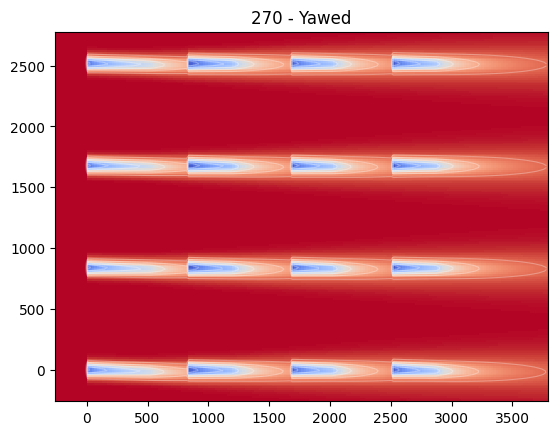

In [70]:
#Plotting the plane.
horizontal_plane = fi_test.calculate_horizontal_plane(wd=[winddir], yaw_angles=np.array([[action]]) , height=90.0)
visualize_cut_plane(horizontal_plane, title="270 - Yawed")
print(action)